In [1]:
!pip install opencv-python pandas scikit-learn torch torchvision pillow matplotlib tqdm

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/ProgettoDLA/dataset_resized_3split_augmented_128.zip" "/content/dataset_resized_3split_augmented_128.zip"
!unzip -q "/content/dataset_resized_3split_augmented_128.zip" -d "/content/dataset_resized_3split_augmented_128"

In [4]:
''' !unzip -q "dataset_resized_3split_augmented_128.zip" -d "dataset_resized_3split_augmented_128" '''

In [81]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader

In [82]:
# --- CONFIGURAZIONE ---
ORIGINAL_DATASET_PATH = 'flowers'          # Cartella sorgente
PROCESSED_DIR = 'dataset_resized_3split_augmented_128'  # Output
IMG_SIZE = (128, 128)                      # Dimensione target
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

# SOGLIA BILANCIAMENTO
AUGMENTATION_THRESHOLD = 0.75  # Se una classe ha < 75% del MAX, viene aumentata

# --- 1. DEFINIZIONE FUNZIONI ---

def augment_image(img):
    """Genera varianti dell'immagine (Augmentation)."""
    rows, cols, _ = img.shape

    # A. Flip Orizzontale (50% probabilità)
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # B. Rotazione (range +/- 15 gradi)
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    # C. Luminosità (Variazione +/- 20%)
    value = random.uniform(0.8, 1.2)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 2] = hsv[:, :, 2] * value
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255 # Cap a 255
    hsv = np.array(hsv, dtype=np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return img

def process_and_save(paths, labels, split_name):
    """Salva Val e Test (solo Resize, no Augmentation)."""
    save_dir = os.path.join(PROCESSED_DIR, split_name)
    print(f"Salvando set {split_name}...")

    for src_path, label in tqdm(zip(paths, labels), total=len(paths)):
        class_dir = os.path.join(save_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        img = cv2.imread(src_path)
        if img is None: continue
        img = cv2.resize(img, IMG_SIZE) # Solo resize

        filename = os.path.basename(src_path)
        dst_path = os.path.join(class_dir, filename)
        cv2.imwrite(dst_path, img)

def process_and_balance_train(paths, labels):
    """Processa Train applicando bilanciamento condizionale."""
    save_dir = os.path.join(PROCESSED_DIR, 'train')
    print(f"Elaborazione Train con logica condizionale...")

    # Raggruppa immagini per etichetta
    data_map = {}
    for path, label in zip(paths, labels):
        if label not in data_map: data_map[label] = []
        data_map[label].append(path)

    # 1. Calcola statistiche (MAX e Soglia )
    max_count = max(len(p) for p in data_map.values())
    limit_threshold = int(max_count * AUGMENTATION_THRESHOLD)

    print(f" MAX immagini: {max_count} | SOGLIA : {limit_threshold}")

    for label, class_paths in data_map.items():
        class_dir = os.path.join(save_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        current_count = len(class_paths)

        # --- LOGICA BILANCIAMENTO ---
        # Se la classe è scarsa (< soglia), aumentiamo fino al MAX
        if current_count < limit_threshold:
            target = max_count
            needed = target - current_count
            print(f"   [AUGMENT] '{label}': Genero +{needed} img")
        else:
            # Se la classe è sufficiente, teniamo le originali
            needed = 0
            print(f"   [SKIP]    '{label}': Sufficienti ({current_count})")

        loaded_imgs = []

        # A. Salva Originali (Sempre)
        for src_path in tqdm(class_paths, desc=f"Orig {label}", leave=False):
            img = cv2.imread(src_path)
            if img is None: continue
            img = cv2.resize(img, IMG_SIZE)
            loaded_imgs.append(img)

            filename = os.path.basename(src_path)
            cv2.imwrite(os.path.join(class_dir, filename), img)

        # B. Genera Sintetiche (Solo se needed > 0)
        if needed > 0 and loaded_imgs:
            for i in tqdm(range(needed), desc=f"Augm {label}", leave=False):
                base_img = random.choice(loaded_imgs)       # Pesca a caso
                aug_img = augment_image(base_img.copy())    # Modifica
                aug_filename = f"aug_{i}_{random.randint(1000,9999)}.jpg"
                cv2.imwrite(os.path.join(class_dir, aug_filename), aug_img)

# --- 2. LOGICA MAIN ---

if os.path.exists(PROCESSED_DIR):
    print(f"La cartella '{PROCESSED_DIR}' esiste già. Salto.")
else:
    print(f"Creazione dataset in '{PROCESSED_DIR}'...")
    if not os.path.exists(ORIGINAL_DATASET_PATH):
        raise FileNotFoundError(f"Non trovo: {ORIGINAL_DATASET_PATH}")

    # A. Scansione Cartelle
    data_by_class = {}
    for label in os.listdir(ORIGINAL_DATASET_PATH):
        class_dir = os.path.join(ORIGINAL_DATASET_PATH, label)
        if os.path.isdir(class_dir):
            data_by_class[label] = []
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(VALID_EXTENSIONS):
                    data_by_class[label].append(os.path.join(class_dir, fname))

    if not data_by_class: raise ValueError("Nessuna immagine trovata!")

    # B. Appiattimento liste
    all_paths, all_labels = [], []
    for label, paths in data_by_class.items():
        all_paths.extend(paths)
        all_labels.extend([label]*len(paths))

    # C. Split Stratificato (Mantiene le proporzioni originali)
    # 1. Separa Train (80%) da Temp (20%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_paths, all_labels, test_size=0.20, stratify=all_labels, random_state=42
    )
    # 2. Divide Temp in Val (10%) e Test (10%)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42
    )

    # D. Esecuzione Processamento
    process_and_balance_train(train_paths, train_labels) # Augmentation solo qui
    process_and_save(val_paths, val_labels, 'val')
    process_and_save(test_paths, test_labels, 'test')

    print("\nDataset creato!")

# --- 3. VERIFICA E MAPPA ---
train_dir_final = os.path.join(PROCESSED_DIR, 'train')
if os.path.exists(train_dir_final):
    # Crea mappa classi (Label -> Indice)
    classes = sorted([d for d in os.listdir(train_dir_final) if os.path.isdir(os.path.join(train_dir_final, d))])
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    print("\n--- Mappa Classi ---")
    print(class_to_idx)

    # Conta file finali per conferma bilanciamento
    print("\n--- Distribuzione Train Finale ---")
    for cls in classes:
        n_files = len(os.listdir(os.path.join(train_dir_final, cls)))
        print(f"Classe {cls}: {n_files} immagini")

Creazione dataset in 'dataset_resized_3split_augmented_128'...
Elaborazione Train con logica condizionale...
 MAX immagini: 843 | SOGLIA : 632
   [SKIP]    'water_lily': Sufficienti (786)


   [AUGMENT] 'lotus': Genero +443 img


   [SKIP]    'iris': Sufficienti (843)


   [SKIP]    'rose': Sufficienti (799)


   [SKIP]    'common_daisy': Sufficienti (784)


   [SKIP]    'bellflower': Sufficienti (698)


   [SKIP]    'black_eyed_susan': Sufficienti (800)


   [SKIP]    'magnolia': Sufficienti (838)


   [AUGMENT] 'lavender': Genero +443 img


   [SKIP]    'dandelion': Sufficienti (842)


   [SKIP]    'calendula': Sufficienti (782)


   [SKIP]    'california_poppy': Sufficienti (818)


   [SKIP]    'tulip': Sufficienti (838)


   [AUGMENT] 'orchid': Genero +452 img


   [SKIP]    'coreopsis': Sufficienti (838)


   [SKIP]    'daffodil': Sufficienti (776)


   [AUGMENT] 'astilbe': Genero +253 img


   [SKIP]    'carnation': Sufficienti (738)


   [SKIP]    'sunflower': Sufficienti (822)


Salvando set val...


100%|██████████| 1723/1723 [00:02<00:00, 641.05it/s]


Salvando set test...


100%|██████████| 1723/1723 [00:02<00:00, 649.50it/s]


Dataset creato!

--- Mappa Classi ---
{'astilbe': 0, 'bellflower': 1, 'black_eyed_susan': 2, 'calendula': 3, 'california_poppy': 4, 'carnation': 5, 'common_daisy': 6, 'coreopsis': 7, 'daffodil': 8, 'dandelion': 9, 'iris': 10, 'lavender': 11, 'lotus': 12, 'magnolia': 13, 'orchid': 14, 'rose': 15, 'sunflower': 16, 'tulip': 17, 'water_lily': 18}

--- Distribuzione Train Finale ---
Classe astilbe: 843 immagini
Classe bellflower: 698 immagini
Classe black_eyed_susan: 800 immagini
Classe calendula: 782 immagini
Classe california_poppy: 818 immagini
Classe carnation: 738 immagini
Classe common_daisy: 784 immagini
Classe coreopsis: 838 immagini
Classe daffodil: 776 immagini
Classe dandelion: 842 immagini
Classe iris: 843 immagini
Classe lavender: 843 immagini
Classe lotus: 843 immagini
Classe magnolia: 838 immagini
Classe orchid: 843 immagini
Classe rose: 799 immagini
Classe sunflower: 822 immagini
Classe tulip: 838 immagini
Classe water_lily: 786 immagini


In [84]:
def load_dataset(split_name):
    base_path = os.path.join(PROCESSED_DIR, split_name)
    if not os.path.exists(base_path): return np.array([]), np.array([])

    images, labels = [], []
    # Mappa classi dinamica
    classes = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
    class_to_idx = {c: i for i, c in enumerate(classes)}

    print(f"Caricamento {split_name} (Classi: {classes})...")

    for cls_name, cls_idx in class_to_idx.items():
        cls_dir = os.path.join(base_path, cls_name)
        fnames = os.listdir(cls_dir)
        # Carichiamo solo un sample per velocità di test, rimuovi [:100] per caricare tutto
        for fname in tqdm(fnames, leave=False):
            img_path = os.path.join(cls_dir, fname)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img / 255.0
                images.append(img)
                labels.append(cls_idx)

    return np.array(images, dtype=np.float32), np.array(labels)

# Carichiamo per verificare
X_train, y_train = load_dataset('train')
X_val, y_val = load_dataset('val')
X_test, y_test = load_dataset('test')

print(f"\nSTATISTICHE FINALI:")
print(f"Train shape: {X_train.shape} (Bilanciato!)")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

Caricamento train (Classi: ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'lavender', 'lotus', 'magnolia', 'orchid', 'rose', 'sunflower', 'tulip', 'water_lily'])...


Caricamento val (Classi: ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'lavender', 'lotus', 'magnolia', 'orchid', 'rose', 'sunflower', 'tulip', 'water_lily'])...


Caricamento test (Classi: ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'lavender', 'lotus', 'magnolia', 'orchid', 'rose', 'sunflower', 'tulip', 'water_lily'])...



STATISTICHE FINALI:
Train shape: (15374, 128, 128, 3) (Bilanciato!)
Val shape:   (1723, 128, 128, 3)
Test shape:  (1723, 128, 128, 3)


=== STATISTICHE DATASET TRAIN ===
Numero totale immagini: 15374
Dimensione immagine: 128x128 con 3 canali
Valore minimo pixel: 0.00
Valore massimo pixel: 1.00

--- Conteggio Classi Train ---
Classe 0 (astilbe): 843 immagini
Classe 1 (bellflower): 698 immagini
Classe 2 (black_eyed_susan): 800 immagini
Classe 3 (calendula): 782 immagini
Classe 4 (california_poppy): 818 immagini
Classe 5 (carnation): 738 immagini
Classe 6 (common_daisy): 784 immagini
Classe 7 (coreopsis): 838 immagini
Classe 8 (daffodil): 776 immagini
Classe 9 (dandelion): 842 immagini
Classe 10 (iris): 843 immagini
Classe 11 (lavender): 843 immagini
Classe 12 (lotus): 843 immagini
Classe 13 (magnolia): 838 immagini
Classe 14 (orchid): 843 immagini
Classe 15 (rose): 799 immagini
Classe 16 (sunflower): 822 immagini
Classe 17 (tulip): 838 immagini
Classe 18 (water_lily): 786 immagini

--- Conteggio Classi Val ---
Classe 0 (astilbe): 74 immagini
Classe 1 (bellflower): 88 immagini
Classe 2 (black_eyed_susan): 100 immagini
Cla

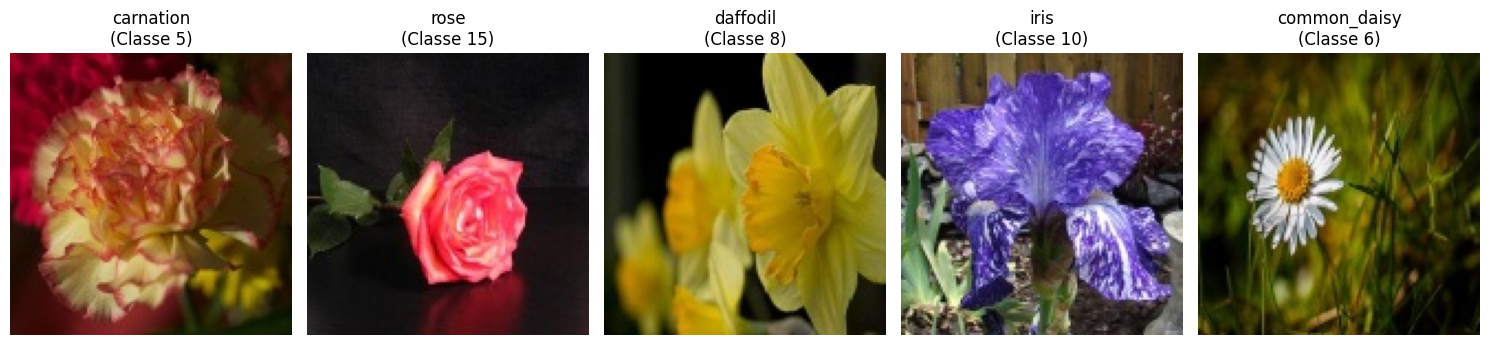

In [85]:
# --- 1. INFO NUMERICHE ---
# Definiamo il percorso del training set processato
train_dir = os.path.join(PROCESSED_DIR, 'train')

# 1. Troviamo i nomi delle cartelle (che sono le nostre classi)
# È IMPORTANTE usare 'sorted' per garantire che l'ordine sia sempre lo stesso (0, 1, 2...)
classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# 2. Creiamo la mappa Classe -> Indice (utile per il training)
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
print("=== STATISTICHE DATASET TRAIN ===")
print(f"Numero totale immagini: {X_train.shape[0]}")
print(f"Dimensione immagine: {X_train.shape[1]}x{X_train.shape[2]} con {X_train.shape[3]} canali")
print(f"Valore minimo pixel: {X_train.min():.2f}")
print(f"Valore massimo pixel: {X_train.max():.2f}")

print("\n--- Conteggio Classi Train ---")
unique, counts = np.unique(y_train, return_counts=True)
idx_to_class = {v: k for k, v in class_to_idx.items()} # Mappa inversa utile

for label_idx, count in zip(unique, counts):
    nome_classe = idx_to_class[label_idx]
    print(f"Classe {label_idx} ({nome_classe}): {count} immagini")

print("\n--- Conteggio Classi Val ---")
unique_val, counts_val = np.unique(y_val, return_counts=True)
for label_idx, count in zip(unique_val, counts_val):
    nome_classe = idx_to_class[label_idx]
    print(f"Classe {label_idx} ({nome_classe}): {count} immagini")

print("\n--- Conteggio Classi Test ---")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for label_idx, count in zip(unique_test, counts_test):
    nome_classe = idx_to_class[label_idx]
    print(f"Classe {label_idx} ({nome_classe}): {count} immagini")

# --- 2. VISUALIZZAZIONE ESEMPI ---
print("\nESEMPI VISIVI RANDOM")
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i in range(5):
    idx_random = np.random.randint(0, len(X_train))
    img = X_train[idx_random]
    label = y_train[idx_random]
    nome_label = idx_to_class[label]

    axes[i].imshow(img)
    axes[i].set_title(f"{nome_label}\n(Classe {label})")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [86]:
# 1. Configurazione Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando accelerazione Apple MPS (Metal)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando accelerazione CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("MPS e CUDA non trovati, uso CPU")

Usando accelerazione CUDA (GPU)


In [87]:
# 2. Conversione da Numpy a Tensor
# PyTorch vuole (N, Canali, Altezza, Larghezza) -> usiamo permute
# Assicuriamoci che siano float32
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 3. DataLoader
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dati caricati nei Loader. Batch size: {batch_size}")

Dati caricati nei Loader. Batch size: 32


In [88]:
import torch.nn as nn

class OptimizedCNN(nn.Module):
    def __init__(self, num_classes):
        super(OptimizedCNN, self).__init__()

        # --- BLOCCO ESTRAZIONE FEATURES ---
        # Nota: Impostiamo bias=False perché la Batch Normalization successiva
        # introduce già un termine di "shift" (beta), rendendo il bias della conv ridondante.

        # Blocco 1: Low-level features
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True), # inplace=True risparmia memoria
            nn.MaxPool2d(2, 2)  # 128 -> 64
        )

        # Blocco 2: Mid-level features
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 64 -> 32
        )

        # Blocco 3: High-level features
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 32 -> 16
        )

        # Blocco 4: Semantic features
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 16 -> 8
        )

        # --- CLASSIFICATORE ---
        # Global Average Pooling: riduce drasticamente i parametri
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.75), # Regolarizzazione
            nn.Linear(256, num_classes)
        )

        # Inizializzazione pesi esplicita
        self._initialize_weights()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        """
        Applica la He Initialization (Kaiming) come raccomandato
        per evitare che la varianza si dimezzi a causa della ReLU.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # mode='fan_out' preserva la varianza nel passaggio backward
                # nonlinearity='relu' è fondamentale per il calcolo del fattore sqrt(2/n)
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                # Inizializzazione standard per BN: peso=1, bias=0
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                # Per il layer lineare finale
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

NUM_CLASSES = len(class_to_idx)
print(f"Configurazione modello per {NUM_CLASSES} classi.")

model = OptimizedCNN(num_classes=NUM_CLASSES)
# Calcolo parametri
params = sum(p.numel() for p in model.parameters())
print(f"Modello creato. Parametri totali: {params:,}")

Configurazione modello per 19 classi.
Modello creato. Parametri totali: 393,779


In [ ]:
def print_confusion_matrix(all_labels, all_preds, classes, model):
  # Calcolo della matrice di confusione
  cm = confusion_matrix(all_labels, all_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(12, 12))

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

  # Disegna la matrice
  # cmap=plt.cm.Blues usa una scala di blu. Puoi usare anche plt.cm.Reds, plt.cm.Greens, etc.
  disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', values_format='.0%')

  plt.title("Matrice di Confusione Normalizzata (Test Set)")
  plt.savefig(f"confusion_matrix_{model}_batch_{batch_size}_dropout_25.png")
  plt.show()

In [ ]:
#  CONFIGURAZIONE TRAIN
lr = 5e-3
weight_decay = 1e-5
EPOCHS = 50
PATIENCE = 10  # Numero di epoche da attendere senza miglioramenti prima di fermarsi
print("")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(class_to_idx)

# 1. Creazione del Modello
model = OptimizedCNN(num_classes=NUM_CLASSES).to(device)

# 2. Ottimizzatore
# weight_decay implementa la Regolarizzazione L2
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# 3. Scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9)
print(f"CONFIGURAZIONE ATTUALE")

print(f"Epoche:          {EPOCHS}")
print(f"Early Stopping:  Patience = {PATIENCE}")
print(f"Learning Rate:   {lr:.1e}")           # Stampa la variabile lr
print(f"Weight Decay:    {weight_decay:.1e}") # Stampa la variabile weight_decay
print(f"SCHEDULER")
print(f"Gamma:           {scheduler.gamma} (moltiplicatore LR)")

# 4. Loss Function
criterion = nn.CrossEntropyLoss()

print(f"Inizio training su device: {device}")

# Variabili per Early Stopping
best_val_acc = 0.0
patience_counter = 0

# Liste per lo storico
history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}

# --- TRAINING LOOP ---
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoca {epoch+1}/{EPOCHS}", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistiche
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item())

    # Aggiornamento Scheduler
    scheduler.step()

    # Calcolo metriche Training
    epoch_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    current_lr = optimizer.param_groups[0]['lr']

    # --- VALIDATION LOOP ---
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val

    # Salvataggio storico
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    print(f"Epoca {epoch+1:02d} | LR: {current_lr:.1e} | Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # --- EARLY STOP ---
    # Controlliamo se l'accuratezza in validazione è migliorata
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0  # Reset contatore
        # Salviamo il modello migliore (checkpoint)
        torch.save(model.state_dict(), f'cnn_best_model_batch_{batch_size}_dropout_25.pth')
    else:
        patience_counter += 1
        print(f" Nessun miglioramento. Patience: {patience_counter}/{PATIENCE}")

        # Se abbiamo superato la pazienza, fermiamo il training
        if patience_counter >= PATIENCE:
            print("\nEARLY STOPPING ACTIVATED")
            print(f"Il training si ferma perché la Val Acc non migliora da {PATIENCE} epoche.")
            break

print("Training completato!")


CONFIGURAZIONE ATTUALE
Epoche:          50
Early Stopping:  Patience = 10
Learning Rate:   5.0e-03
Weight Decay:    1.0e-05
SCHEDULER
Gamma:           0.9 (moltiplicatore LR)
Inizio training su device: cuda


Epoca 01 | LR: 4.5e-03 | Loss: 2.0928 | Train Acc: 29.87% | Val Acc: 36.91%


Epoca 02 | LR: 4.1e-03 | Loss: 1.8384 | Train Acc: 39.55% | Val Acc: 40.28%


Epoca 03 | LR: 3.6e-03 | Loss: 1.6520 | Train Acc: 46.02% | Val Acc: 44.69%


Epoca 04 | LR: 3.3e-03 | Loss: 1.4828 | Train Acc: 51.40% | Val Acc: 52.70%


Epoca 05 | LR: 3.0e-03 | Loss: 1.3758 | Train Acc: 55.70% | Val Acc: 59.95%


Epoca 06 | LR: 2.7e-03 | Loss: 1.2515 | Train Acc: 60.15% | Val Acc: 57.63%
 Nessun miglioramento. Patience: 1/10


Epoca 07 | LR: 2.4e-03 | Loss: 1.1735 | Train Acc: 62.87% | Val Acc: 65.82%


Epoca 08 | LR: 2.2e-03 | Loss: 1.0891 | Train Acc: 65.31% | Val Acc: 64.94%
 Nessun miglioramento. Patience: 1/10


Epoca 09 | LR: 1.9e-03 | Loss: 1.0079 | Train Acc: 68.02% | Val Acc: 67.27%


Epoca 10 | LR: 1.7e-03 | Loss: 0.9451 | Train Acc: 70.56% | Val Acc: 69.47%


Epoca 11 | LR: 1.6e-03 | Loss: 0.8782 | Train Acc: 72.59% | Val Acc: 73.53%


Epoca 12 | LR: 1.4e-03 | Loss: 0.8363 | Train Acc: 73.39% | Val Acc: 74.64%


Epoca 13 | LR: 1.3e-03 | Loss: 0.7799 | Train Acc: 75.00% | Val Acc: 72.43%
 Nessun miglioramento. Patience: 1/10


Epoca 14 | LR: 1.1e-03 | Loss: 0.7379 | Train Acc: 76.73% | Val Acc: 77.37%


Epoca 15 | LR: 1.0e-03 | Loss: 0.7028 | Train Acc: 77.82% | Val Acc: 77.77%


Epoca 16 | LR: 9.3e-04 | Loss: 0.6744 | Train Acc: 78.91% | Val Acc: 80.33%


Epoca 17 | LR: 8.3e-04 | Loss: 0.6468 | Train Acc: 79.63% | Val Acc: 79.69%
 Nessun miglioramento. Patience: 1/10


Epoca 18 | LR: 7.5e-04 | Loss: 0.6164 | Train Acc: 80.77% | Val Acc: 78.35%
 Nessun miglioramento. Patience: 2/10


Epoca 19 | LR: 6.8e-04 | Loss: 0.5956 | Train Acc: 80.97% | Val Acc: 80.50%


Epoca 20 | LR: 6.1e-04 | Loss: 0.5713 | Train Acc: 81.87% | Val Acc: 81.31%


Epoca 21 | LR: 5.5e-04 | Loss: 0.5584 | Train Acc: 82.53% | Val Acc: 78.35%
 Nessun miglioramento. Patience: 1/10


Epoca 22 | LR: 4.9e-04 | Loss: 0.5429 | Train Acc: 82.69% | Val Acc: 81.08%
 Nessun miglioramento. Patience: 2/10


Epoca 23 | LR: 4.4e-04 | Loss: 0.5215 | Train Acc: 83.94% | Val Acc: 82.76%


Epoca 24 | LR: 4.0e-04 | Loss: 0.5100 | Train Acc: 84.08% | Val Acc: 81.14%
 Nessun miglioramento. Patience: 1/10


Epoca 25 | LR: 3.6e-04 | Loss: 0.4943 | Train Acc: 84.26% | Val Acc: 81.37%
 Nessun miglioramento. Patience: 2/10


Epoca 26 | LR: 3.2e-04 | Loss: 0.4888 | Train Acc: 84.42% | Val Acc: 81.95%
 Nessun miglioramento. Patience: 3/10


Epoca 27 | LR: 2.9e-04 | Loss: 0.4804 | Train Acc: 84.87% | Val Acc: 81.89%
 Nessun miglioramento. Patience: 4/10


Epoca 28 | LR: 2.6e-04 | Loss: 0.4648 | Train Acc: 85.36% | Val Acc: 81.49%
 Nessun miglioramento. Patience: 5/10


Epoca 29 | LR: 2.4e-04 | Loss: 0.4540 | Train Acc: 85.70% | Val Acc: 82.47%
 Nessun miglioramento. Patience: 6/10


Epoca 30 | LR: 2.1e-04 | Loss: 0.4552 | Train Acc: 85.40% | Val Acc: 82.65%
 Nessun miglioramento. Patience: 7/10


Epoca 31 | LR: 1.9e-04 | Loss: 0.4382 | Train Acc: 86.02% | Val Acc: 82.82%


Epoca 32 | LR: 1.7e-04 | Loss: 0.4388 | Train Acc: 85.96% | Val Acc: 82.94%


Epoca 33 | LR: 1.5e-04 | Loss: 0.4407 | Train Acc: 86.01% | Val Acc: 82.24%
 Nessun miglioramento. Patience: 1/10


Epoca 34 | LR: 1.4e-04 | Loss: 0.4287 | Train Acc: 86.46% | Val Acc: 83.23%


Epoca 35 | LR: 1.3e-04 | Loss: 0.4283 | Train Acc: 86.43% | Val Acc: 83.05%
 Nessun miglioramento. Patience: 1/10


Epoca 36 | LR: 1.1e-04 | Loss: 0.4215 | Train Acc: 86.93% | Val Acc: 82.82%
 Nessun miglioramento. Patience: 2/10


Epoca 37 | LR: 1.0e-04 | Loss: 0.4150 | Train Acc: 87.13% | Val Acc: 83.17%
 Nessun miglioramento. Patience: 3/10


Epoca 38 | LR: 9.1e-05 | Loss: 0.4213 | Train Acc: 86.82% | Val Acc: 83.23%
 Nessun miglioramento. Patience: 4/10


Epoca 39 | LR: 8.2e-05 | Loss: 0.4078 | Train Acc: 87.10% | Val Acc: 83.05%
 Nessun miglioramento. Patience: 5/10


Epoca 40 | LR: 7.4e-05 | Loss: 0.4143 | Train Acc: 86.94% | Val Acc: 83.28%


Epoca 41 | LR: 6.7e-05 | Loss: 0.4152 | Train Acc: 86.94% | Val Acc: 83.05%
 Nessun miglioramento. Patience: 1/10


Epoca 42 | LR: 6.0e-05 | Loss: 0.4043 | Train Acc: 87.18% | Val Acc: 83.46%


Epoca 43 | LR: 5.4e-05 | Loss: 0.3997 | Train Acc: 87.46% | Val Acc: 82.94%
 Nessun miglioramento. Patience: 1/10


Epoca 44 | LR: 4.8e-05 | Loss: 0.4013 | Train Acc: 87.37% | Val Acc: 83.23%
 Nessun miglioramento. Patience: 2/10


Epoca 45 | LR: 4.4e-05 | Loss: 0.4038 | Train Acc: 87.10% | Val Acc: 83.58%


Epoca 46 | LR: 3.9e-05 | Loss: 0.3931 | Train Acc: 87.32% | Val Acc: 83.05%
 Nessun miglioramento. Patience: 1/10


Epoca 47 | LR: 3.5e-05 | Loss: 0.3961 | Train Acc: 87.56% | Val Acc: 83.75%


Epoca 48 | LR: 3.2e-05 | Loss: 0.4024 | Train Acc: 87.17% | Val Acc: 83.28%
 Nessun miglioramento. Patience: 1/10


Epoca 49 | LR: 2.9e-05 | Loss: 0.3964 | Train Acc: 87.33% | Val Acc: 83.63%
 Nessun miglioramento. Patience: 2/10


Epoca 50 | LR: 2.6e-05 | Loss: 0.3902 | Train Acc: 87.71% | Val Acc: 83.75%
 Nessun miglioramento. Patience: 3/10
Training completato!


In [ ]:
''' # 1. Creazione del Modello
model = OptimizedCNN(num_classes=NUM_CLASSES).to(device) '''

--- VALUTAZIONE CUSTOM CNN SU TEST SET ---
Accuracy finale sul Test Set: 86.54%


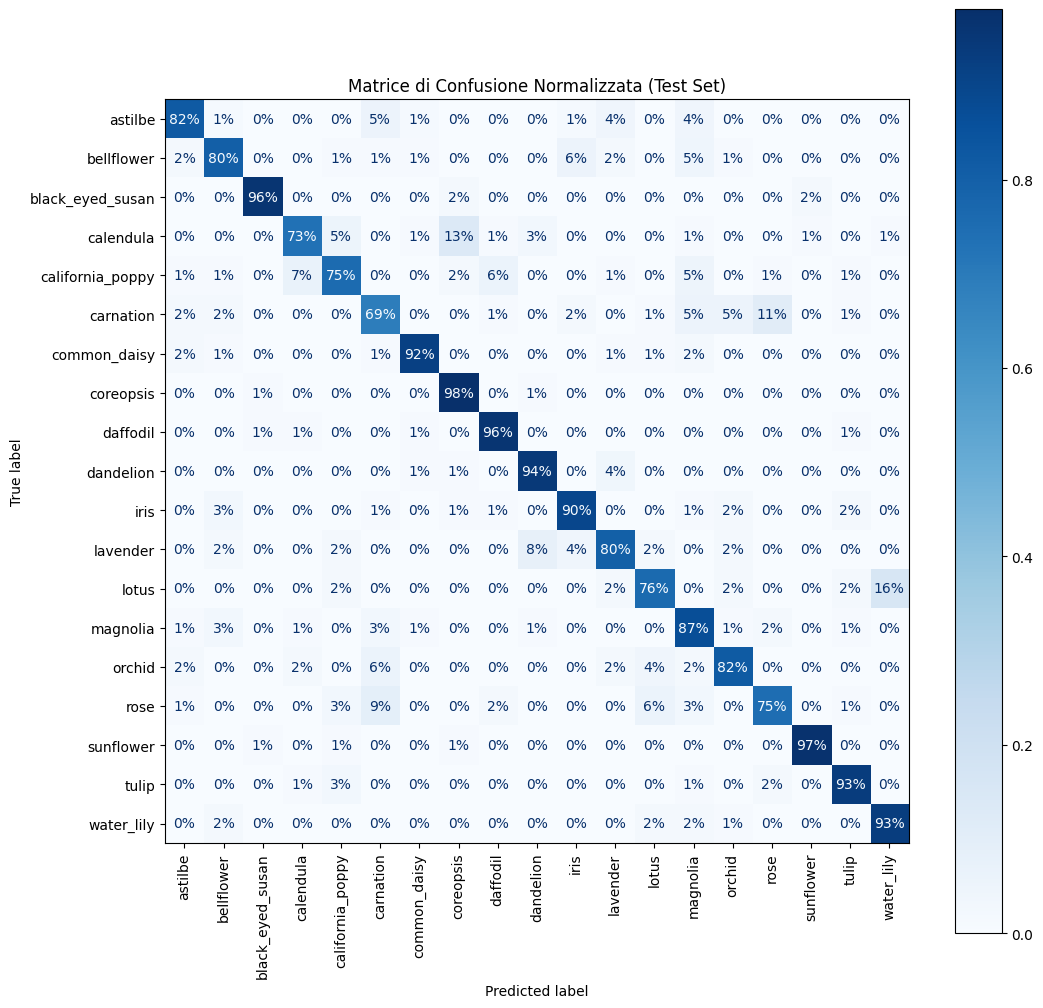

In [38]:
print("--- VALUTAZIONE CUSTOM CNN SU TEST SET ---")
# Carica i pesi migliori prima di uscire/testare
# model.load_state_dict(torch.load('cnn_best_model_batch_32.pth'))
#print(f"Caricati i pesi del modello migliore con Val Acc: {best_val_acc:.2f}%")
model.eval()
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader: # Usa TEST set
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Salviamo per eventuale matrice di confusione
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct_test / total_test
print(f"Accuracy finale sul Test Set: {test_acc:.2f}%")
class_names = [k for k, v in sorted(class_to_idx.items(), key=lambda item: item[1])]

# Calcolo della matrice di confusione
print_confusion_matrix(all_labels, all_preds, classes=class_names, model='custom_cnn')

In [15]:
# Stampa il report completo
print("--- REPORT DI CLASSIFICAZIONE DETTAGLIATO CUSTOM CNN ---\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

--- REPORT DI CLASSIFICAZIONE DETTAGLIATO CUSTOM CNN ---

                  precision    recall  f1-score   support

         astilbe       0.88      0.82      0.85        73
      bellflower       0.81      0.83      0.82        87
black_eyed_susan       0.96      0.92      0.94       100
       calendula       0.82      0.72      0.77        98
california_poppy       0.88      0.79      0.84       102
       carnation       0.74      0.67      0.70        93
    common_daisy       0.91      0.95      0.93        98
       coreopsis       0.83      0.95      0.88       105
        daffodil       0.90      0.97      0.93        97
       dandelion       0.93      0.94      0.94       105
            iris       0.90      0.92      0.91       106
        lavender       0.82      0.74      0.78        50
           lotus       0.79      0.82      0.80        50
        magnolia       0.78      0.85      0.81       105
          orchid       0.74      0.80      0.76        49
            r

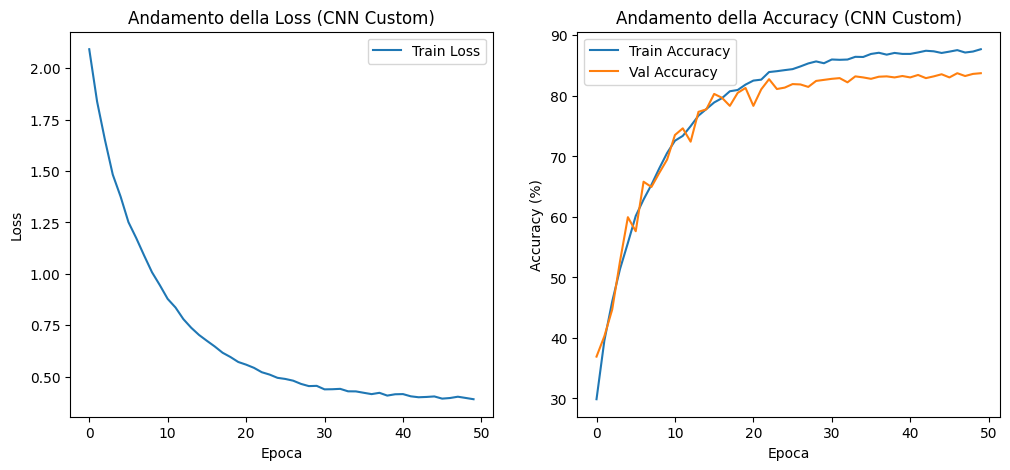

In [ ]:
plt.figure(figsize=(12, 5))

# Grafico Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Andamento della Loss (CNN Custom)')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

# Grafico Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy') # Questo è il validation!
plt.title('Andamento della Accuracy (CNN Custom)')
plt.xlabel('Epoca')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f"loss_plot_custom_cnn_batch_{batch_size}_dropout_25.png")
plt.show()

In [94]:
# --- 1. CONFIGURAZIONE MODELLO ---
weights_mb2 = models.MobileNet_V2_Weights.DEFAULT
model_mb2 = models.mobilenet_v2(weights=weights_mb2)

model_mb2.classifier[0] = nn.Dropout(p=0.25)
in_features = model_mb2.classifier[1].in_features
model_mb2.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

model_mb2 = model_mb2.to(device)

print(f"Modello V2 pronto. Parametri addestrabili: {sum(p.numel() for p in model_mb2.parameters() if p.requires_grad):,}")

# --- 2. CONFIGURAZIONE TRAINING ---
optimizer = optim.Adam(model_mb2.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
epochs_transfer = 30
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

# Liste per storico
history_mb2 = {'train_loss': [], 'train_acc': [], 'val_acc': []}

# --- VARIABILI PER EARLY STOPPING ---
best_val_acc = 0.0
patience_counter = 0
PATIENCE = 5  # Numero di epoche di tolleranza prima di fermarsi

print(f"\n=== INIZIO TRAINING (MobileNetV2) con Early Stopping (Patience={PATIENCE}) ===")

for epoch in range(epochs_transfer):
    # --- TRAIN ---
    model_mb2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Prendiamo il LR corrente per stamparlo
    current_lr = optimizer.param_groups[0]['lr']

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs_transfer}", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_mb2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # --- VALIDATION ---
    model_mb2.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_mb2(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val

    # Salvataggio storico
    history_mb2['train_loss'].append(epoch_loss)
    history_mb2['train_acc'].append(train_acc)
    history_mb2['val_acc'].append(val_acc)

    # Step dello scheduler
    scheduler.step()

    # Print delle statistiche dell'epoca
    print(f"Epoca {epoch+1:02d} | LR: {current_lr:.1e} | Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # --- EARLY STOPPING & CHECKPOINT ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0  # Reset contatore
        # Salviamo il modello migliore (checkpoint)
        torch.save(model_mb2.state_dict(), f'mobilenetv2_best_model_batch_{batch_size}_dropout_25.pth')
    else:
        patience_counter += 1
        print(f"Nessun miglioramento. Patience: {patience_counter}/{PATIENCE}")

        # Se abbiamo superato la pazienza, fermiamo il training
        if patience_counter >= PATIENCE:
            print("\nEARLY STOPPING ACTIVATED")
            print(f"Il training si ferma perché la Val Acc non migliora da {PATIENCE} epoche.")
            break

print("\nTraining MobileNetV2 completato!")

Modello V2 pronto. Parametri addestrabili: 2,248,211

=== INIZIO TRAINING (MobileNetV2) con Early Stopping (Patience=5) ===


Epoca 01 | LR: 1.0e-05 | Loss: 2.7021 | Train Acc: 25.17% | Val Acc: 52.47%


Epoca 02 | LR: 9.8e-06 | Loss: 2.0565 | Train Acc: 56.46% | Val Acc: 67.09%


Epoca 03 | LR: 9.6e-06 | Loss: 1.5013 | Train Acc: 67.71% | Val Acc: 75.57%


Epoca 04 | LR: 9.4e-06 | Loss: 1.1318 | Train Acc: 74.63% | Val Acc: 79.74%


Epoca 05 | LR: 9.2e-06 | Loss: 0.8835 | Train Acc: 79.00% | Val Acc: 82.65%


Epoca 06 | LR: 9.0e-06 | Loss: 0.7332 | Train Acc: 81.20% | Val Acc: 83.98%


Epoca 07 | LR: 8.9e-06 | Loss: 0.6368 | Train Acc: 83.17% | Val Acc: 85.20%


Epoca 08 | LR: 8.7e-06 | Loss: 0.5673 | Train Acc: 84.66% | Val Acc: 86.36%


Epoca 09 | LR: 8.5e-06 | Loss: 0.5113 | Train Acc: 86.09% | Val Acc: 87.35%


Epoca 10 | LR: 8.3e-06 | Loss: 0.4659 | Train Acc: 86.95% | Val Acc: 87.99%


Epoca 11 | LR: 8.2e-06 | Loss: 0.4315 | Train Acc: 87.77% | Val Acc: 87.70%
Nessun miglioramento. Patience: 1/5


Epoca 12 | LR: 8.0e-06 | Loss: 0.3995 | Train Acc: 88.75% | Val Acc: 88.22%


Epoca 13 | LR: 7.8e-06 | Loss: 0.3735 | Train Acc: 89.47% | Val Acc: 88.33%


Epoca 14 | LR: 7.7e-06 | Loss: 0.3501 | Train Acc: 89.94% | Val Acc: 88.28%
Nessun miglioramento. Patience: 1/5


Epoca 15 | LR: 7.5e-06 | Loss: 0.3275 | Train Acc: 90.55% | Val Acc: 88.97%


Epoca 16 | LR: 7.4e-06 | Loss: 0.3108 | Train Acc: 91.10% | Val Acc: 88.57%
Nessun miglioramento. Patience: 1/5


Epoca 17 | LR: 7.2e-06 | Loss: 0.2932 | Train Acc: 91.70% | Val Acc: 89.03%


Epoca 18 | LR: 7.1e-06 | Loss: 0.2743 | Train Acc: 91.93% | Val Acc: 89.67%


Epoca 19 | LR: 7.0e-06 | Loss: 0.2628 | Train Acc: 92.44% | Val Acc: 89.67%
Nessun miglioramento. Patience: 1/5


Epoca 20 | LR: 6.8e-06 | Loss: 0.2506 | Train Acc: 92.90% | Val Acc: 89.67%
Nessun miglioramento. Patience: 2/5


Epoca 21 | LR: 6.7e-06 | Loss: 0.2351 | Train Acc: 93.22% | Val Acc: 89.67%
Nessun miglioramento. Patience: 3/5


Epoca 22 | LR: 6.5e-06 | Loss: 0.2216 | Train Acc: 93.89% | Val Acc: 90.08%


Epoca 23 | LR: 6.4e-06 | Loss: 0.2167 | Train Acc: 93.85% | Val Acc: 89.84%
Nessun miglioramento. Patience: 1/5


Epoca 24 | LR: 6.3e-06 | Loss: 0.2039 | Train Acc: 94.19% | Val Acc: 90.48%


Epoca 25 | LR: 6.2e-06 | Loss: 0.1951 | Train Acc: 94.46% | Val Acc: 90.48%
Nessun miglioramento. Patience: 1/5


Epoca 26 | LR: 6.0e-06 | Loss: 0.1861 | Train Acc: 94.69% | Val Acc: 90.89%


Epoca 27 | LR: 5.9e-06 | Loss: 0.1750 | Train Acc: 95.17% | Val Acc: 90.89%
Nessun miglioramento. Patience: 1/5


Epoca 28 | LR: 5.8e-06 | Loss: 0.1714 | Train Acc: 95.21% | Val Acc: 90.54%
Nessun miglioramento. Patience: 2/5


Epoca 29 | LR: 5.7e-06 | Loss: 0.1686 | Train Acc: 95.27% | Val Acc: 90.60%
Nessun miglioramento. Patience: 3/5


Epoca 30 | LR: 5.6e-06 | Loss: 0.1553 | Train Acc: 95.69% | Val Acc: 90.89%
Nessun miglioramento. Patience: 4/5

Training MobileNetV2 completato!


In [95]:
''' # --- 1. CONFIGURAZIONE MODELLO ---
weights_mb2 = models.MobileNet_V2_Weights.DEFAULT
model_mb2 = models.mobilenet_v2(weights=weights_mb2)

model_mb2.classifier[0] = nn.Dropout(p=0.5)
in_features = model_mb2.classifier[1].in_features
model_mb2.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

model_mb2 = model_mb2.to(device) '''

' # --- 1. CONFIGURAZIONE MODELLO ---\nweights_mb2 = models.MobileNet_V2_Weights.DEFAULT\nmodel_mb2 = models.mobilenet_v2(weights=weights_mb2)\n\nmodel_mb2.classifier[0] = nn.Dropout(p=0.5)\nin_features = model_mb2.classifier[1].in_features\nmodel_mb2.classifier[1] = nn.Linear(in_features, NUM_CLASSES)\n\nmodel_mb2 = model_mb2.to(device) '

--- VALUTAZIONE MOBILENET V2 SU TEST SET ---
Accuracy finale MobileNet V2 sul Test Set: 92.46%


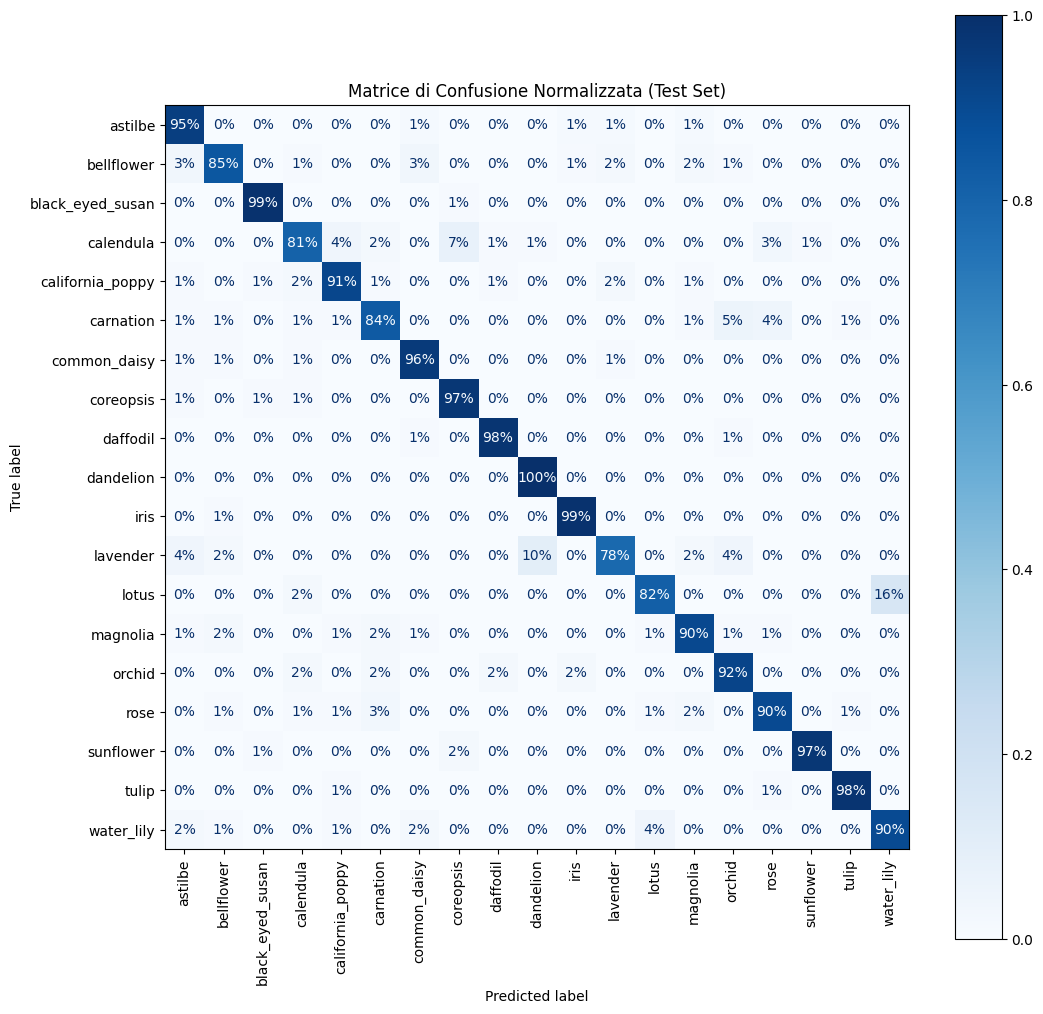

In [96]:
print("--- VALUTAZIONE MOBILENET V2 SU TEST SET ---")
# model_mb2.load_state_dict(torch.load(f'mobilenetv2_best_model_batch_32.pth'))
model_mb2.eval()
correct_test = 0
total_test = 0
all_preds_mb2 = []
all_labels_mb2 = []

with torch.no_grad():
    for inputs, labels in test_loader: # Usa TEST set
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_mb2(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Salviamo per eventuale matrice di confusione
        all_preds_mb2.extend(predicted.cpu().numpy())
        all_labels_mb2.extend(labels.cpu().numpy())

test_acc = 100 * correct_test / total_test
print(f"Accuracy finale MobileNet V2 sul Test Set: {test_acc:.2f}%")

print_confusion_matrix(all_labels_mb2, all_preds_mb2, classes=class_names, model='mobilenet')

In [97]:
# Stampa il report completo
print("--- REPORT DI CLASSIFICAZIONE DETTAGLIATO MOBILENET V2 ---\n")
print(classification_report(all_labels_mb2, all_preds_mb2, target_names=class_names))

--- REPORT DI CLASSIFICAZIONE DETTAGLIATO MOBILENET V2 ---

                  precision    recall  f1-score   support

         astilbe       0.85      0.95      0.90        73
      bellflower       0.90      0.85      0.88        87
black_eyed_susan       0.97      0.99      0.98       100
       calendula       0.90      0.81      0.85        98
california_poppy       0.91      0.91      0.91       102
       carnation       0.90      0.84      0.87        93
    common_daisy       0.92      0.96      0.94        98
       coreopsis       0.91      0.97      0.94       105
        daffodil       0.97      0.98      0.97        97
       dandelion       0.95      1.00      0.97       105
            iris       0.97      0.99      0.98       106
        lavender       0.87      0.78      0.82        50
           lotus       0.87      0.82      0.85        50
        magnolia       0.92      0.90      0.91       105
          orchid       0.82      0.92      0.87        49
           

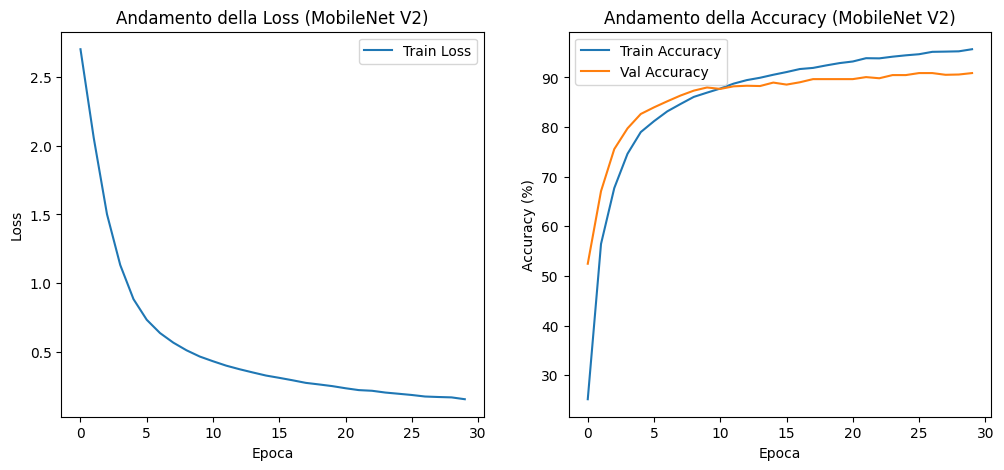

In [98]:
plt.figure(figsize=(12, 5))

# Grafico Loss
plt.subplot(1, 2, 1)
plt.plot(history_mb2['train_loss'], label='Train Loss')
plt.title('Andamento della Loss (MobileNet V2)')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

# Grafico Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mb2['train_acc'], label='Train Accuracy')
plt.plot(history_mb2['val_acc'], label='Val Accuracy') # Questo è il validation!
plt.title('Andamento della Accuracy (MobileNet V2)')
plt.xlabel('Epoca')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f"loss_plot_mobilenet_batch_{batch_size}_dropout_25.png")
plt.show()